# Lab Group A37: Assignment 1 Cart Pole

## Team: InSync

Contributions:

1) Lim Boon Hian (U2120791F)

- Physics method and explanations.

2) Tio Guo Yong (U2123181B)

- Proximal Policy Optimisation (PPO) method and explanations.

# Note
# - This notebook is best viewed with Google Colab. Please open this notebook in Google Colab for the video to load.
# - You need to run the notebook sequentially from the start until the end to avoid any dependency issues.

### Installing dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


### Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

### Understanding the cart pole environment

We will use the cart pole environment provided by Gym. [[1]](#reference)

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialisation can be achieved by the code below, which returns the observation of the initial state.

The observation space is a array, which return 4 values. The details of these values are as follows [[1]](#reference):

| Index      | Details |  Note |
| ----------- | ----------- | ----------- |
| 0   | Cart Position         | Positive = On the right, Negative = On the left
| 1   | Cart Velocity         | Positive = Move towards right, Negative = Move towards left
| 2   | Pole Angle            | Positive = Tilted to the right, Negative = Tilted to the left
| 3   | Pole Angular Velocity | Positive = Rotate clockwise, Negative = Rotate anti-clockwise  

<br>According to gym documentation [[1]](#reference), the episode ends when:

- Pole Angle is greater than ±12°
- Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
- Episode length is greater than 500

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00068887  0.00546972  0.04707896 -0.036665  ]


For the cart pole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For this environment, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. We get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.00057947 -0.19029462  0.04634565  0.27049226]
Reward for this step: 1.0
Is this round done? False


In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Physics Agent

### Task 1: Development of the agent

We will use a Physics-based agent based on the following policy.

In [ ]:
def theta_omega_policy(obs):
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1

#### Random state sampling
We sample one random set of observations. Then, we feed the observation set into the Physics agent to output one corresponding action.

In [ ]:
env = gym.make("CartPole-v1")

In [ ]:
observation = env.reset()
action = theta_omega_policy(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.04898144  0.04750277 -0.02293599  0.01143248]
Chosen action: 1


### Task 2: Demonstrate the effectiveness of the agent

In [ ]:
MAX_EPISODE = 100
MAX_ACTIONS = 500

In [ ]:
def test_policy(policy_func, episodeNum = MAX_EPISODE, max_actions = MAX_ACTIONS, verbose=False):
    final_rewards = []
    for episode in range(episodeNum):
        if verbose and episode % 50 == 0:
            print(episode)
        episode_rewards = 0
        obs = env.reset()  # reset to a random position
        for step in range(max_actions):
            action = policy_func(obs)
            obs, reward, done, info = env.step(action)
            episode_rewards += reward
            if done:
                break
        final_rewards.append(episode_rewards)
    return final_rewards

In [ ]:
def plot_policy(final_rewards, policy_name:str=''):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.std(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

In [ ]:
rand_rewards = test_policy(theta_omega_policy)

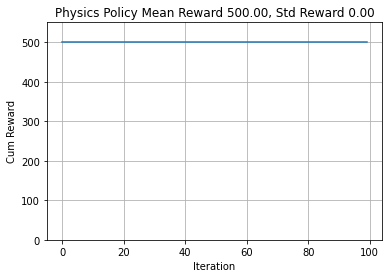

In [ ]:
pt = plot_policy(rand_rewards, "Physics Policy")

In [ ]:
def average(lst):
    return sum(lst) / len(lst)

In [ ]:
print("Average cumulative reward:", average(rand_rewards))
print("Is my agent good enough?", average(rand_rewards) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


We can see that the Physics agent performs very well on average with a mean reward of 500.

### Task 3: Render one episode played by the agent

We will see the Physics agent performing in the cart pole environment for one episode and render the process.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    action = theta_omega_policy(observation) # Calling Physics agent
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

### Task 4: Explain your approach and analyze the output

This agent is built based on [[3]](#reference).

θ: the angle between the pole and the vertical position (positive means clock-wise)

ω: angular velocity of the pole (positive means rotating clock-wise)

Physical agents make use of θ (theta) and ω (omega) to decide the action, that is why the policy is called theta-omega policy. 

The algorithm works as follows:

If the angle θ is small (<0.03):
	
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Omega Policy)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Push to left if the pole is rotating anti-clockwise, Push to right if the pole is rotating clockwise.

Else if the angle θ is large:
	
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(Theta Policy)
	
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Push to left if the pole is tilted to the left, push to right if the pole is tilted to the right.

The idea behind theta policy is to push the cart to the direction where the pole is tilted towards. For example, if the pole is tilted to the right, we can just push the cart to the right to compensate it. This is a simple and good idea, until we realize that in some scenarios, it does not work right:
Imagine a scenario, where the pole is almost balance (say θ < 0.03), the pole is tilted to the right (θ>0) and the pole is currently moving anticlockwise (ω < 0) to compensate the action. Based on theta policy, we know we will push the cart to the right as θ>0. However, this would lead to the cart gaining much more anticlockwise angular acceleration it does not need, such that it overshoots past the center and tilt largely to the left.

Hence, we use omega policy to compensate this situation. In omega policy, we try to slow down the angular velocity by looking at the velocity. For example, if velocity goes anticlockwise, we will push the cart to the left to compensate. As this policy monitors the velocity instead of angle, it corrects the pole as soon as it starts rotating. As a result, this policy can stop the pole from rotating. 

However, as the policy does not care about the angle, if the cart is tilted to one direction too much (say θ > 0.03), the cart will just move toward that direction horizontally until it moves too far away from the origin. For example, say the cart is tilted to the right at the start, then the pole will have the tendency to rotate clockwise. As soon as the pole rotate clockwise, the omega policy will stop the pole from rotating by pushing the cart to the right. However, the tendency of moving clockwise will still be there as the pole is still tilted to the right. Hence, the policy will keep pushing the cart to the right to stop the pole from rotating, and eventually, the cart will be pushed too far away from the origin, ending the episode.

Hence, we should combine theta policy and omega policy together, such that whenever the angle of the pole is small (θ < 0.03), we will just use omega policy, but when the angle is too large (θ > 0.03) and the cart starts to move toward one directions horizontally, we will use theta policy to correct the angle such that the pole will not have any tendency to rotate clockwise or anticlockwise.

Noted that 0.03 is just a threshold we pick for the policy. It is said that the threshold can be anywhere between 0.02 to 0.04.


<h1><span style = 'color:red;'>Note: You have to restart the runtime before running the following section!</span></h1>

## Proximal Policy Optimisation (PPO) Agent

For the second method, we will use a reinforcement learning algorithm named Proximal Policy Optimisation (PPO). In general, the environment, action space, observation space, and the maximum cumulative reward are the same as those in the Physics agent above.

## Installing Dependencies

You may have to re-run the following code twice for the dependencies to install sucessfully.

In [ ]:
# May need to run twice
!pip3 install setuptools==65.5.0
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra] pyglet==1.5.27

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:10 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Hit:11 http://security.ubuntu.com/ubuntu focal-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
free

In [ ]:
import stable_baselines3
stable_baselines3.__version__

'1.7.0'

## Training RL Agent

To develop the model, either run the training step below to train a new PPO agent or upload the trained model to this notebook in Google Collab.

#### Train the PPO agent from stratch

Uncomment the following code if you want to train a new PPO agent.

In [ ]:
"""
import gym 
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

environment_name = "CartPole-v1"

env = gym.make(environment_name)
env = DummyVecEnv([lambda: env])
model = PPO('MlpPolicy', env, verbose = 1)

model.learn(total_timesteps=100000)

import os
PPO_path = os.path.join('PPO_model_HT')
model.save(PPO_path)
"""

Using cpu device


For this implementation, we will be using PPO algorithms and policy evaluation methods from stable baselines 3 library. In particular, we will use MLP policy which incorporates the actor-critic method. [[11]](#reference)

Parameters:
- policy = 'MlpPolicy' is the policy used in actor-critic algorithms.
- verbose = 1 means info messages are printed for each episode.
- total_timesteps = 100000 means the PPO agent will be trained up to or once 100000 timesteps have been exceeded.

Default values: 
- learning rate = 0.00003
- number of steps to run for each environment for every update = 2048
- minibatch size = 64
- number of epoch during the optimisation of objective function loss = 10
- discount factor, γ = 0.99
- clip range, ϵ = 0.2

#### Load the PPO agent

Steps to upload the trained model onto Google Collab:

1) Open the 'Files' section on the left column.

2) Drag the zip file named 'PPO_model_HT' onto the 'Files section'. Alternatively, click the upload button to upload the zip file.

3) After the file has been uploaded, you can proceed with the following code to load the model.

In [ ]:
import gym 
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

model_path = os.path.join('PPO_model_HT')
env = gym.make("CartPole-v1")
env = DummyVecEnv([lambda: env])
model = PPO.load(model_path, env=env)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, env, n_eval_episodes=10, render=False)

/usr/local/lib/python3.9/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(500.0, 0.0)

### Task 1: Development of an RL agent

In [ ]:
env = gym.make("CartPole-v1")
env = DummyVecEnv([lambda: env])
obs = env.reset()
action, _states = model.predict(obs)
print("Observation:", obs)
print("Action:",action)

Observation: [[-0.00255051 -0.00445799  0.03204943  0.00305235]]
Action: [1]


### Task 2: Demonstrate the effectiveness of the RL agent

In [ ]:
def plot_policy(final_rewards, policy_name:str=''):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    print(len(final_rewards))
    fig = plt.plot(range(len(final_rewards)), final_rewards)
    plt.grid()
    plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.std(final_rewards)))
    plt.ylabel('Cum Reward')
    plt.xlabel('Iteration')
    plt.ylim(0, max(final_rewards)*1.1)
    return fig

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
final_rewards_float,final_rewards_int = evaluate_policy(model, env, n_eval_episodes=100, render=False, return_episode_rewards = True)

100


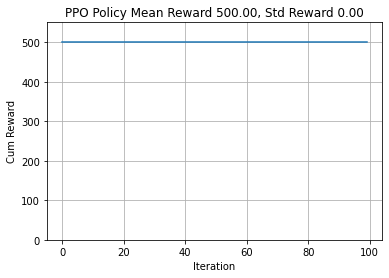

In [ ]:
pt = plot_policy(final_rewards_float, "PPO Policy")

In [ ]:
def average(lst):
    return sum(lst) / len(lst)

In [ ]:
print("Average cumulative reward:", average(final_rewards_float))
print("Is my agent good enough?", average(final_rewards_float) > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


We can see that the PPO agent performs very well on average with a mean reward of 500.

### Task 3: Render one episode played by the agent

The following code is written based on [[2]](#reference).

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix='', video_folder='video/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make('CartPole-v1')])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [ ]:
record_video('CartPole-v1', model, video_length=500, prefix='ppo-cartpole')

Saving video to /content/video/ppo-cartpole-step-0-to-step-500.mp4


In [ ]:
show_videos('video', prefix='ppo')

### Task 4: Explain your approach and analyze the output

In our model, we used Proximal Policy Optimisation (PPO). It is a model-free, on-policy reinforcement learning algorithim.

The algorithm works as follows: [[10]](#reference)

In every iteration, there are N parallel actors. Each actor will determine the policy, π<sub>θ</sub> in the environment for T timesteps (see Actor-critic section) and subsequently compute the advantage estimates for each timestep. (see Advantage estimates section)

Afterwards, the algorithm will optimise objective function L (see Objective function section), with K epochs, minibatch size M $\leq$ NT and clipping.

At the end of every iteration, the old policy is updated with the new policy within the clipping range.

### Actor-critic
Unlike some other reinforcement learning algorithms, PPO focuses on the 'safe' update of the policy function to minimise the variance during training. This means that the updated policy improves by at most a certain clipping range. Here, we use ϵ = 0.2. [[4]](#reference)

In the actor-critic method, we have the actor model and the critic model. In this cart pole environment, the actor model receives the 4 values - cart position, cart velocity, pole angle, and pole angular velocity. Then, it outputs the corresponding action - either 0 (to the left) or 1 (to the right). The action is performed by the agent in the cart pole environment to produce the next set of observations. The resulting observations are transformed into rewards and become inputs into the critic model. The critic model then outputs the Q-value of the action taken in the previous state. By comparing this Q-value, the actor model can update the policy function to take better actions. Intuitively, the longer the cart pole stays upright, the higher the Q-value and the better the policy will become. [[4]](#reference)

### Advantage estimates
The advantage function, A<sub>t</sub>, estimates measure the degree of improvement or decline in the action taken compared to the overall expected return (cumulative rewards). [[5]](#reference) The equation is as follows: [[10]](#reference)

\begin{equation} 
  \hat{A_t} = δ_t + (γλ)δ_{t+1} + ... + (γλ)^{T-t+1}δ_{T-1}
\end{equation}
where
\begin{equation} 
  δ_t = r_t + γV(s_{t+1}) - V(s_t)
\end{equation}

### Objective function
The objective function L<sub>t</sub> is as follows: [[10]](#reference)
\begin{equation} 
  L_t(θ) = min(r_t(θ)\hat{A_t},clip(r_t(θ)), 1 - ϵ, 1 + ϵ)\hat{A_t}
\end{equation}

In our case, the PPO algorithm uses Adam optimiser to optimise the objective function loss from a random samples of 64 in one epoch. 10 epochs are run on the same trajectory sample which consists of states, actions, and cumulative rewards. [[9]](#reference)

In the objective function, the ratio function [[6]](#reference)
\begin{equation} 
  r_t(θ) = \frac{π_θ(a_t | s_t)}{π_{θ_{old}} (a_t | s_t)}
\end{equation}
is the ratio between the new policy and the old policy when the policy is updated. In our case, the maximum tolerable change in policy is 0.2 or 20%.

## Conclusion

Both physics and PPO are policy-based methods and both agents perform perform very well in the cart pole environment, achieving maximum cumulative rewards on average.

## Reference

[1] “Cart Pole - Gym Documentation.” https://www.gymlibrary.dev/environments/classic_control/cart_pole/ (accessed Mar. 18, 2023).

[2] A. Raffin, “Stable Baselines3 RL tutorial.” Mar. 16, 2023. Accessed: Mar. 18, 2023. [Online]. Available: https://github.com/araffin/rl-tutorial-jnrr19

[3] J. Xu, “How to Beat the CartPole Game in 5 Lines,” Medium, Feb. 21, 2021. https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f (accessed Mar. 18, 2023).

[4] C. Trivedi, “Proximal Policy Optimization Tutorial (Part 1: Actor-Critic Method),” Medium, Aug. 12, 2019. https://towardsdatascience.com/proximal-policy-optimization-tutorial-part-1-actor-critic-method-d53f9afffbf6 (accessed Mar. 18, 2023).

[5] R. Tangri, “Generalized Advantage Estimate: Maths and Code,” Medium, May 12, 2021. https://towardsdatascience.com/generalized-advantage-estimate-maths-and-code-b5d5bd3ce737 (accessed Mar. 18, 2023).

[6] T. Simonini, “Proximal Policy Optimization (PPO).” https://huggingface.co/blog/deep-rl-ppo (accessed Mar. 18, 2023).

[7] J. Schulman, O. Klimov, F. Wolski, P. Dhariwal, and A. Radford, “Proximal Policy Optimization,” Jul. 20, 2017. https://openai.com/research/openai-baselines-ppo (accessed Mar. 18, 2023).

[8] S. Patrikar, “Batch, Mini Batch & Stochastic Gradient Descent,” Medium, Oct. 01, 2019. https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a (accessed Mar. 18, 2023).

[9] T. Kim, “Understanding and Implementing Proximal Policy Optimization (Schulman et al., 2017),” Medium, May 06, 2021. https://towardsdatascience.com/understanding-and-implementing-proximal-policy-optimization-schulman-et-al-2017-9523078521ce (accessed Mar. 18, 2023).

[10] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, “Proximal Policy Optimization Algorithms.” arXiv, Aug. 28, 2017. doi: 10.48550/arXiv.1707.06347.

[11] “PPO - Stable Baselines3” https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html (accessed Mar. 18, 2023).